<a target="_blank" href="https://colab.research.google.com/github/sotirischatzimiltis/PhD/blob/main/Code/NoPeek/noPeekCifar10.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="" # declare explisitly which GPU to use, "" means use all available GPUs

In [2]:
# ensure print method of Python3.x is used even if you run code in Python2.x
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras

import keras
from keras.layers import Flatten, Dense, Reshape
from keras.layers import Input,InputLayer,Activation, ZeroPadding2D, BatchNormalization,Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Sequential,Model
from keras.optimizers import SGD, Adam
# allows to save the best model, allows to modify learning rate during training and reduce learning rate based on conditions
from keras.callbacks import ModelCheckpoint,LearningRateScheduler, ReduceLROnPlateau
from keras import losses
from keras.datasets import mnist, cifar10
# provide a backend abstraction layer
from keras import backend as K
from keras import models, layers, regularizers, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

from sklearn.utils import shuffle
from sklearn import preprocessing
import scipy.io
# plot data in a 3D space
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd
import sys
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")



In [3]:
def tf_print(op, tensors, message=""):
    def print_message(x):
        #print(x)
        sys.stdout.write("\n DEBUG: " + message + " %s\n" % x)
        return x
    prints = [tf.compat.v1.py_func(print_message, [tensor], tensor.dtype) for tensor in tensors]
    with tf.control_dependencies(prints):
        op = tf.identity(op)
    return op

def tf_print_2(tensor, tensors):
    def print_message(x):
        #print(x)
        message = ""
        sys.stdout.write("DEBUG: " + message + " %s" % x)
        return x
    #prints = [tf.compat.v1.py_func(print_message, [tensor], tensor.dtype) for tensor in tensors]
    prints = [tf.compat.v1.py_func(print_message, [tensors], tensor.dtype)]
    with tf.control_dependencies(prints):
        tensor = tf.identity(tensor)
    return tensor

# Compute pairwise Euclidean distance matrix between vectors in a batch
def pairwise_dist(A):
    #https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
    # Input: A (represents batch of inputs)
    # Each row in A represents a vector in a batch
    # Compute square euclidean norm of each vector in A
    # Sum along second dimension axis = 1 (columns)
    r = tf.reduce_sum(A*A, axis= 1)
    # Reshape tensor r to have shape [batch_size,1] for the multiplication
    r = tf.reshape(r, [-1, 1])
    # calculate D (square euclidean distance matrix) and cast float
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    D = tf.cast(D,dtype= tf.float32)
    # remove any negative distances
    D = tf.math.maximum(D, 1e-7)
    # compute square root of D
    D = tf.sqrt(D)
    return D

# Compute distance correlation between X and Y
def dist_corr(X, Y):
    # Compute the number of data points in X and cast
    n = tf.cast(tf.shape(X)[0], tf.float32)
    # Compute pariwise Euclidean distances for matrices X and Y
    a = pairwise_dist(X)
    b = pairwise_dist(Y)
    # Calculate: mean values along columns(--->) - mean values along rows + the mean value of the matrix
    # Everything subtracted to center the distances
    A = a - tf.reduce_mean(a, axis=1) - tf.expand_dims(tf.reduce_mean(a, axis=0), axis=1) + tf.reduce_mean(a)
    B = b - tf.reduce_mean(b, axis=1) - tf.expand_dims(tf.reduce_mean(b, axis=0), axis=1) + tf.reduce_mean(b)
    # Calculate covariance and variance
    dCovXY = tf.sqrt(tf.reduce_sum(A*B) / (n ** 2))
    dVarXX = tf.sqrt(tf.reduce_sum(A*A) / (n ** 2))
    dVarYY = tf.sqrt(tf.reduce_sum(B*B) / (n ** 2))

    # Compute correlation
    dCorXY = dCovXY / tf.sqrt(dVarXX * dVarYY)
    print(dCorXY)
    return dCorXY

# Distance correlation loss function
def custom_loss1(y_true,y_pred):
    #y_pred = tf_print(y_pred, [tf.reduce_sum(y_pred)], message="y_pred is")
    dcor = dist_corr(y_true,y_pred)
    #dcor = tf_print(dcor, [tf.reduce_sum(dcor)], message="dcor is")
    return dcor

# Cross Entropy loss function
def custom_loss2(y_true,y_pred):
    #y_pred = tf_print(y_pred, [tf.reduce_sum(y_pred)], message="y_pred is")
    recon_loss = losses.categorical_crossentropy(y_true, y_pred)
    return recon_loss

α1DCOR(X, Z) + α2CCE(Ytrue, Y)

In [4]:
# Assign alpha values for the weight of the equation
alpha1, alpha2 = 1000., 0.1
# Declare where you want to split the network
stage_num, block_num = 2, 1
experiment_name = "cifar10_{}_{}_{}_{}".format(alpha1, alpha2, stage_num, block_num)

Set Training Parameters and Read Dataset

In [5]:
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 100
data_augmentation = False
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# n is the number of residual blocks in the network
n = 3
# Computed depth from supplied model parameter n
depth = n * 9 + 2 # this is for version 2

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_trainRaw = x_train
x_testRaw = x_test
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Compute mean image
# If subtract mean image from training and test set if enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

ResNet Implementation

In [13]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-4
    if epoch > 180:
        lr = 1e-6
    elif epoch > 160:
        lr = 7e-6
    elif epoch > 120:
        lr = 2e-5
    elif epoch > 80:
        lr = 8e-5
    return lr

# Basic ResNet Building Block
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-batch_norm-activation (True) or
            batch_norm-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    # Create a 2D convolutional layer
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    # x is the input tensor
    x = inputs
    # pass x trhough the layer with the order set above
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    # get output
    return x

def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            if stage_num == stage and block_num == res_block:
                before_flatten_dims = x.get_shape().as_list()[1:]
                split_layer = Flatten(name='split_layer')
                split_layer_output = split_layer(x)
                x = Reshape(before_flatten_dims)(split_layer_output)
        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    x = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal',
                    name='softmax')(x)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=[split_layer_output, outputs])
    #model = Model(inputs=inputs, outputs=[outputs])
    return model

model = resnet_v2(input_shape=input_shape, depth=depth)

KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 256), dtype=tf.float32, name=None), name='add_60/add:0', description="created by layer 'add_60'")
[8, 8, 256]
KerasTensor(type_spec=TensorSpec(shape=(None, 16384), dtype=tf.float32, name=None), name='split_layer/Reshape:0', description="created by layer 'split_layer'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 256), dtype=tf.float32, name=None), name='reshape_6/Reshape:0', description="created by layer 'reshape_6'")


In [14]:
model.compile(loss={'split_layer': custom_loss1, 'softmax': custom_loss2},
              loss_weights={'split_layer': alpha1, 'softmax': alpha2},
              optimizer=Adam(lr=lr_schedule(0)),
              metrics={'softmax':'accuracy'})

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), '../saved_models')
model_name = '%s_model.{epoch:03d}.h5' % experiment_name
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=1e-5)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
x_train_flattened = x_train.reshape(50000, 32*32*3)
x_test_flattened = x_test.reshape(10000, 32*32*3)

history = model.fit(x_train, [x_train_flattened, y_train],
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, [x_test_flattened, y_test]),
          shuffle=True,
          callbacks=callbacks,
          verbose=2)


Epoch 1/100
Tensor("custom_loss1/truediv_3:0", shape=(), dtype=float32)
Tensor("custom_loss1/truediv_3:0", shape=(), dtype=float32)


KeyboardInterrupt: ignored

In [15]:
history = model.fit(x_train, [x_train_flattened, y_train],
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, [x_test_flattened, y_test]),
          shuffle=True,
          callbacks=callbacks,
          verbose=2)

Epoch 1/100


KeyboardInterrupt: ignored

In [16]:
x_test_encoded = model.predict(x_test)

313/313 [==============================] - 53s 168ms/step


In [17]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 3, figsize=(25, 6))

    axes[0].plot(history.history['split_layer_loss'], label='Split Layer loss')
    axes[0].plot(history.history['val_split_layer_loss'], label='Split Val loss')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    axes[1].plot(history.history['softmax_loss'], label='Softmax loss')
    axes[1].plot(history.history['val_softmax_loss'], label='Validation softmax loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['softmax_accuracy'], label='Softmax acc')
    axes[2].plot(history.history['val_softmax_accuracy'], label='Validation softmax acc')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()

plot_train_history(history)

NameError: ignored

In [ ]:
experiment_name

ValueError: ignored

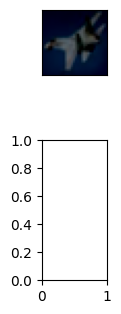

In [18]:
#test raw vs smash
n = 20
plt.figure(figsize=(20, 4))
for i in range(10,20):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i])
    #plt.imshow((x_test[i] * 255).astype(np.int64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test_encoded[0][i].reshape(16, 16, 3))
    #plt.imshow((x_test_encoded[0][i].reshape(32, 32, 3) * 255).astype(np.int64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
out_dir = '/tf/datasets/{}/output/'.format(experiment_name)
inp_dir = '/tf/datasets/{}/input/'.format(experiment_name)
os.makedirs(out_dir)
os.makedirs(inp_dir)
import matplotlib
for i in range(10000):
    #np.save('rawCifar10_baseline/'+str(i), x_test[i],allow_pickle = True)
    #np.save('noSmashCifar10_baseline/'+str(i), x_test_encoded[0][i].reshape(32, 32, 3),allow_pickle = True)
    np.save('{}/{}'.format(out_dir, i), x_test_encoded[0][i].reshape(8, 8, 256),allow_pickle = True)
    np.save('{}/{}'.format(inp_dir, i), x_testRaw[i].reshape(32, 32, 3),allow_pickle = True)

    #matplotlib.image.imsave('rawCifar10/'+str(i)+'.png', x_test[i])
    #matplotlib.image.imsave('smashCifar10/'+str(i)+'.png', x_test_encoded[0][i].reshape(32, 32, 3))

In [ ]:
import pickle
with open('/tf/datasets/{}/trainHistoryDict'.format(experiment_name), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
with open('/tf/datasets/{}/trainHistoryDict2'.format(experiment_name), 'wb') as file_pi:
    pickle.dump(history2.history, file_pi)


In [ ]:
#train raw vs smash
n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_train_encoded[0][i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()